In [ ]:
from src.tools import MMseqs, NCBIDatasets, Prodigal
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from src.classifier import Classifier
from src.sampler import Sampler
from src.genome import ReferenceGenome
from src.dataset import Dataset
import re
from src.build import * 

%load_ext autoreload 
%autoreload 2

[197] [34.95177665]


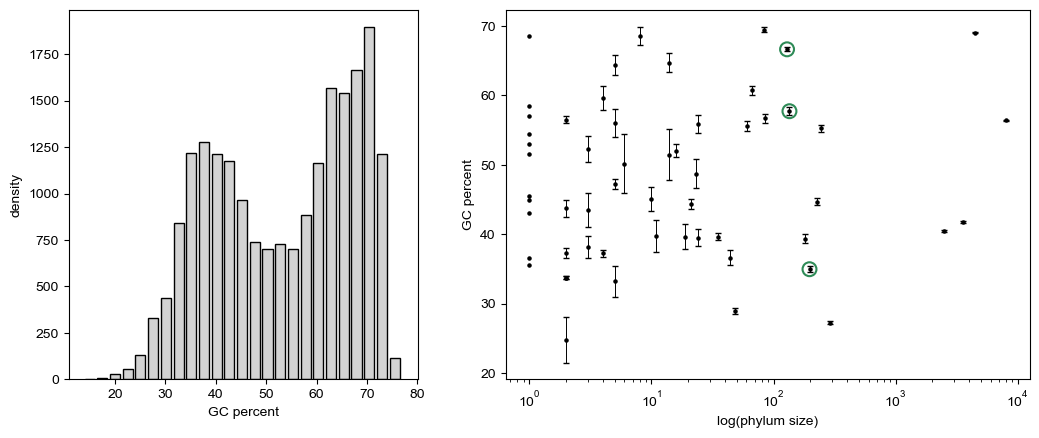

In [16]:
ncbi_genome_metadata_df = load_ncbi_genome_metadata()

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(2 * 6.2, 4.8), width_ratios=[0.4, 0.6])

counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
ax_a.set_ylabel('density')
ax_a.set_xlabel('GC percent')

level = 'phylum'
y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean().values # .sort_values(ascending=True)
x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False).values # .sort_values(ascending=True)
y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]
ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
ax_b.scatter(x, y, color='black', s=5)

phyla = ncbi_genome_metadata_df.groupby(level).first().index
print(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'])
ax_b.scatter(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'], facecolor='none',linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
ax_b.scatter(x[phyla == 'Planctomycetota'], y[phyla == 'Planctomycetota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
ax_b.scatter(x[phyla == 'Deinococcota'], y[phyla == 'Deinococcota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)

ax_b.set_xscale('log')
ax_b.set_xlabel(f'log({level} size)')
ax_b.set_ylabel('GC percent')

plt.show()

In [ ]:

# Start by selecting a few phyla in a reasonable size range with varying GC contents.
def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

    phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
    phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

    genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
    phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
    phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
    phyla = dict()
    phyla['low_gc_content'] = phylum_gc_percent.index[0]
    phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
    phyla['high_gc_content'] = phylum_gc_percent.index[-1]

    print('Low-GC content phylum:', phyla['low_gc_content'])
    print('Medium-GC content phylum:', phyla['med_gc_content'])
    print('High-GC content phylum:', phyla['high_gc_content'])

    genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
    return genome_ids

genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

Low-GC content phylum: Campylobacterota
Medium-GC content phylum: Planctomycetota
High-GC content phylum: Deinococcota


In [16]:
file = GBFFFile('../data/ncbi/gbffs/GCF_000005845.2_genomic.gbff')
df = file.to_df()
df

,feature,contig_id,product,note,pseudo,locus_tag,inference,experiment,ribosomal_slippage,strand,...,continuous,seq,translation_table,codon_start,protein_id,evidence_type,evidence_category,evidence_details,evidence_source,used_pgap
0,CDS,NC_000913,thr operon leader peptide,none,False,b0001,none,none,False,1,...,True,MKRISTTITTTITITTGNGAG,11,1,NP_414542.1,none,none,none,none,False
1,CDS,NC_000913,fused aspartate kinase/homoserine dehydrogenase 1,none,False,b0002,none,none,False,1,...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,11,1,NP_414543.1,none,none,none,none,False
2,CDS,NC_000913,homoserine kinase,none,False,b0003,none,none,False,1,...,True,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,11,1,NP_414544.1,none,none,none,none,False
3,CDS,NC_000913,threonine synthase,none,False,b0004,none,none,False,1,...,True,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,11,1,NP_414545.1,none,none,none,none,False
4,CDS,NC_000913,DUF2502 domain-containing protein YaaX,none,False,b0005,none,none,False,1,...,True,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,11,1,NP_414546.1,none,none,none,none,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,CDS,NC_000913,putative inner membrane protein CreD,none,False,b4400,none,none,False,1,...,True,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,11,1,NP_418817.1,none,none,none,none,False
4638,CDS,NC_000913,DNA-binding transcriptional dual regulator ArcA,none,False,b4401,none,none,False,-1,...,True,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,11,1,NP_418818.1,none,none,none,none,False
4639,CDS,NC_000913,uncharacterized protein YjjY,none,False,b4402,none,none,False,1,...,True,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,11,1,NP_418819.1,none,none,none,none,False
4640,CDS,NC_000913,protein YtjE,none,False,b4824,none,none,False,1,...,True,MSRFIFYKIILSKQKDM,11,1,YP_010283921.1,none,none,none,none,False


In [6]:
genome_metadata_df = list()
for category, genome_ids_ in genome_ids.items():
    df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
    df['gc_percent_category'] = category
    # df = df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')] # Only include genomes annotated with PGAP, because the other files are not consistent. 
    genome_metadata_df.append(df)
genome_metadata_df = pd.concat(genome_metadata_df)
genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
ncbi = NCBIDatasets()
ncbi.run(genome_ids=model_organism_genome_ids, metadata=False)
ncbi.cleanup()

In [32]:
GBFFFile('../data/ncbi/gbffs/GCF_000006765.1_genomic.gbff')

/home/prichter/Documents/tripy/src/__init__.py:41: UserWarning: get_dtypes: Column "source" only contains NaNs. Inferring datatype as strings.
  warnings.warn(f'get_dtypes: Column "{col}" only contains NaNs. Inferring datatype as strings.')


In [26]:
prodigal = Prodigal()
for genome_id in model_organism_genome_ids:
    input_path = f'../data/ncbi/genomes/{genome_id}_genomic.fna'
    output_path = f'../data/proteins/{genome_id}_protein.faa'
    if not os.path.exists(output_path):
        prodigal.run(input_path, output_path)

In [ ]:
for genome_id in model_organism_genome_ids:
    ! ref --input-path ../data/proteins/{genome_id}_protein.faa --output-dir ../data/ref --gbffs-dir ../data/ncbi/gbffs/ --prodigal-output --summarize
# # ! ref --input-path ../data/proteins/GCF_003711085.1_protein.faa --overwrite --output-dir ../data/ref --gbffs-dir ../data/ncbi/gbffs/ --prodigal-output --summarize 

In [ ]:
ref_df = load_ref(genome_ids=[genome_id for genome_id in genome_ids['low_gc_content'] if (genome_id != 'GCF_000009085.1')])

In [ ]:
def build_datasets(genome_metadata_df:pd.DataFrame, phylum:str='Campylobacterota', max_length:int=2000):
    # First remove things which do not have definitive labels. 
    genome_ids = genome_metadata_df[genome_metadata_df.phylum == phylum].index
    genome_ids = [genome_id for genome_id in genome_ids if (genome_id != 'GCF_000009085.1')] # Remove the non-PGAP genome. 

    print(f'build_datasets: Loading data from {len(genome_ids)} genomes belonging to the phylum {phylum}.')
    df = load_ref(genome_ids=genome_ids, add_labels=True)
    df = df.rename(columns={'query_seq':'seq'}) # Need to do this for file writing, etc. to work correctly, 
    df = df.drop(columns=['top_hit_homolog_id', 'top_hit_homolog_seq', 'pseudo'])

    lengths = df.seq.apply(len)
    print(f'Removing {(lengths >= max_length).sum()} sequences exceeding the maximum length of {max_length}')
    df = df[lengths < max_length]
    all_df = df.copy()

    df = df[df.label != 'none'].copy()
    df.label = [0 if (label == 'spurious') else 1 for label in df.label]

    print(f'build_datasets: Loaded {len(df)} sequences, {(df.label == 0).sum()} labeled spurious and {(df.label == 1).sum()} labeled real.')

    real_df, spurious_df = df[df.label == 1].copy(), df[df.label == 0].copy()
    n_real = len(real_df)

    mmseqs = MMseqs()
    real_df = mmseqs.cluster(real_df, job_name=f'{phylum.lower()}_cluster', sequence_identity=0.50, reps_only=True, overwrite=False)
    print(f'build_datasets: Clustering at 50 percent similarity removed {n_real - len(real_df)} sequences.')
    mmseqs.cleanup()

    df = pd.concat([spurious_df, real_df], ignore_index=False)

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = list(gss.split(df, groups=df.genome_id))[0]
    train_df, test_df = df.iloc[train_idxs], df.iloc[test_idxs]
    print(f'build_datasets: {(train_df.label == 0).sum()} negative instances and {(train_df.label == 1).sum()} positive instances in the training dataset.')
    print(f'build_datasets: {(test_df.label == 0).sum()} negative instances and {(test_df.label == 1).sum()} positive instances in the testing dataset.')

    all_df['in_test_dataset'] = all_df.index.isin(test_df.index)
    all_df['in_train_dataset'] = all_df.index.isin(train_df.index)
    
    train_df.to_csv(f'../data/{phylum.lower()}_dataset_train.csv')
    test_df.to_csv(f'../data/{phylum.lower()}_dataset_test.csv')
    all_df.to_csv(f'../data/{phylum.lower()}_dataset.csv')

    return train_df, test_df, all_df 
    
train_df, test_df, all_df = build_datasets(genome_metadata_df)
# phylum ='Campylobacterota'
# dtypes = {'top_hit_partial':str, 'query_partial':str, 'top_hit_translation_table':str, 'top_hit_codon_start':str}
# train_df = pd.read_csv(f'../data/{phylum.lower()}_dataset_train.csv', index_col=0, dtype=dtypes)
# test_df = pd.read_csv(f'../data/{phylum.lower()}_dataset_test.csv', index_col=0, dtype=dtypes)


build_datasets: Loading data from 196 genomes belonging to the phylum Campylobacterota.
Removing 383 sequences exceeding the maximum length of 2000
build_datasets: Loaded 357263 sequences, 297 labeled spurious and 356966 labeled real.
MMseqs.load: Removing 300625 non-cluster representatives.
build_datasets: Clustering at 50 percent similarity removed 300625 sequences.
build_datasets: 240 negative instances and 43785 positive instances in the training dataset.
build_datasets: 57 negative instances and 12556 positive instances in the testing dataset.


In [41]:
# I want to get a rough estimate of how many spurious sequences we can expect in a genome, which I think I will need to use
# model organisms for. I need genomes which do not have suspect genes in the reference, i.e. those which are not based solely on ab initio prediction
# and have no annotation. 
ref_df = load_ref(genome_ids=model_organism_genome_ids, add_labels=False)

for genome_id, df in ref_df.groupby('genome_id'):
    print(genome_id, (df.n_hits == 0).sum())

GCF_000005845.2 101
GCF_000006765.1 74
GCF_000009045.1 28
GCF_000195955.2 108


In [48]:
ref_df = load_ref(genome_ids=model_organism_genome_ids, add_labels=False)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

class BenchmarkClassifier():

    def __init__(self, feature_col:str='query_length'):

        self.model = LogisticRegression(class_weight='balanced', C=1) # , multi_class='multinomial') 
        self.scaler = StandardScaler()
        self.feature_col = feature_col

    def predict(self, df:pd.DataFrame, include_outputs:bool=True):
        X = df[[self.feature_col]].values
        X = self.scaler.transform(X)
        model_labels = self.model.predict(X)
        model_outputs = self.model.predict_proba(X)

        return model_labels if (not include_outputs) else (model_labels, model_outputs)

    def fit(self, df:pd.DataFrame):
        X, labels = df[[self.feature_col]].values, df['label'].values
        X = self.scaler.fit_transform(X)
        self.model.fit(X, labels)

model = BenchmarkClassifier()
model.fit(train_df)

df = test_df[['label', 'query_length']].copy()
df['model_label'], outputs = model.predict(test_df, include_outputs=True)
df['model_output_0'], df['model_output_1'] = outputs[:, 0].ravel(), outputs[:, 1].ravel()

print('Balanced accuracy:', balanced_accuracy_score(df.label.values, df.model_label.values))
print('Precision (class 0):', precision(df, class_=0))
print('Recall (class 0):', recall(df, class_=0))
print('Number of false negatives:', ((df.label == 1) & (df.model_label == 0)).sum())


confusion_matrix = np.where((df.model_label == 1) & (df.label == 0), 'false positive', '')
confusion_matrix = np.where((df.model_label  == 1) & (df.label == 1), 'true positive', confusion_matrix)
confusion_matrix = np.where((df.model_label == 0) & (df.label == 1), 'false negative', confusion_matrix)
confusion_matrix = np.where((df.model_label  == 0) & (df.label == 0), 'true negative', confusion_matrix)
df['confusion_matrix'] = confusion_matrix

benchmark_fn = df[df.confusion_matrix == 'false negative'].index
fn = pred_df[pred_df.confusion_matrix == 'false negative'].index
np.intersect1d(fn, benchmark_fn)

Balanced accuracy: 0.8372044119537454
Precision (class 0): 0.0004276702662247407
Recall (class 0): 0.07017543859649122
Number of false negatives: 3207


AttributeError: 'DataFrame' object has no attribute 'confusion_matrix'

In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 


In [ ]:
# # Curious about the distribution of overlap sizes... 


# def figure(ref_df:pd.DataFrame, path:str=None, min_overlap_fraction:float=0.8):
#     # ref_df = load_ref(genome_ids=genome_ids)
#     ref_df = ref_df[ref_df.spurious | ref_df.real].copy()

#     fig = plt.figure(figsize=(10, 10), layout='tight')
#     grid = GridSpec(nrows=1, ncols=1, figure=fig)
#     ax_a = fig.add_subplot(grid[0, 0])

#     ax_a_df = pd.DataFrame(index=ref_df.index)
#     ax_a_df['length'] = get_lengths(ref_df, top_hit=False, units='nt')
#     ax_a_df['overlap_length'] = ref_df['top_hit_overlap_length']
#     ax_a_df['overlap_fraction'] = ax_a_df.overlap_length / ax_a_df.length # This is relative to the query sequence. 
#     ax_a_df['label'] = np.select([ref_df.real, ref_df.spurious], ['real', 'spurious'], default='none')
#     if min_overlap_fraction is not None:
#         ax_a_df = ax_a_df[ax_a_df.overlap_fraction > min_overlap_fraction].copy()

#     colors = ['darkseagreen', 'indianred']
#     # sns.kdeplot(data=ax_a_df, ax=ax_a, hue='label', hue_order=['real', 'spurious'], palette=colors, common_norm=False, x='overlap_fraction')
#     sns.ecdfplot(data=ax_a_df, ax=ax_a, hue='label', hue_order=['real', 'spurious'], palette=colors, x='overlap_fraction')

#     plt.show()
#     return ax_a_df


# ax_a_df = figure(ref_df, min_overlap_fraction=None)